# Requirement

1. 데이터가 저장된 주소를 3번째 셀의 path값으로 설정
2. 마지막 셀에서 결과 파일을 저장하고자 하는 주소를 원하는 주소로 변경
3. 필요에 따라 Google Drive Import 이후 실행.

In [1]:
#필요한 Module Import 
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import cv2
import shutil 
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import Google Drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
path = '/content/gdrive/MyDrive/2021-2/2학기과목/딥러닝/프로젝트/' #데이터들이 저장된 path 

In [4]:
#위 path에서 가져올 각각의 데이터들에 대한 세부 path
positive_cases_path = os.path.join(path + 'CT_COVID')
negative_cases_path = os.path.join(path + 'CT_NonCOVID')
lc_train_path = os.path.join(path + 'LC')


In [5]:
#각각의 path에 대한 .png파일과 일부 .path에 대한 jpg파일 LOAD
positive_CT_images=glob(os.path.join(positive_cases_path,"*.png"))
negative_CT_images=glob(os.path.join(negative_cases_path,"*.png"))
negative_CT_images.extend(glob(os.path.join(negative_cases_path,"*.jpg")))
lc_train_img=glob(os.path.join(lc_train_path,"*.png"))


In [6]:
label_train = pd.read_excel(lc_train_path+'/train_label.xlsx',names = ['name','label'],header=None) #Label값 LOAD

In [7]:
#label_train.head(10)

In [8]:
label_train_dic = dict(zip(label_train.name, label_train.label)) #Label값을 dictionary 형태로 저장

In [9]:
#label_train_dic

In [10]:
#lc_train_img[0][65:]

In [11]:
#Lung Cancer Image를 LABEL에 따라 구분
positive_LC_images = []
negative_LC_images = []

for k in lc_train_img:
  if label_train_dic[k[65:]] == 0:
    positive_LC_images.append(k)
  else:
    negative_LC_images.append(k)


In [12]:
#COVID DATA 구분(class / path / image)
covid={'class':'Covid_CT','path': positive_cases_path,'images':positive_CT_images}
non_covid={'class':'NonCovid_CT','path':negative_cases_path,'images':negative_CT_images}

In [13]:
#Lung Cancer DATA 구분(class / path / image)
lc = {'class':'LC','path': lc_train_img,'images':positive_LC_images}
non_lc = {'class':'NonLC','path': lc_train_img,'images':negative_LC_images}

In [14]:
# Covid data 디렉토리 구성
subdirs=['Train/COVID/','Test/COVID/']
for subdir in subdirs:
    labeldirs=['Covid_CT','NonCovid_CT']
    for labeldir in labeldirs:
        newdir=subdir+labeldir 
        os.makedirs(newdir,exist_ok='True')

In [15]:
# Lung Cancer data 디렉토리 설정
subdirs=['Train/LC/','Test/LC/']
for subdir in subdirs:
    labeldirs=['LC','NonLC']
    for labeldir in labeldirs:
        newdir=subdir+labeldir 
        os.makedirs(newdir,exist_ok='True')

In [16]:
#subdirs=['Main/']
#for subdir in subdirs:
#    labeldirs=['Test']
#    for labeldir in labeldirs:
#        newdir=subdir+labeldir 
#        os.makedirs(newdir,exist_ok='True')

In [17]:
# COVID DATA에 대해 랜덤하게 Test Set 분리
random.seed(123)
test_ratio=0.2

for cases in [covid,non_covid]:
    total_cases=len(cases['images'])
    num_to_select=(int)(total_cases*test_ratio)
    #print(num_to_select,total_cases)
    random_files_list=random.sample(cases['images'],num_to_select)
    for files in random_files_list:
        shutil.copy(files,'Test/COVID/'+cases['class'])

In [18]:
# Lung Cacner DATA에 대해 랜덤하게 Test Set 분리
random.seed(123)
test_ratio=0.2

for cases in [lc,non_lc]:
    total_cases=len(cases['images'])
    num_to_select=(int)(total_cases*test_ratio)
    #print(num_to_select,total_cases)
    random_files_list=random.sample(cases['images'],num_to_select)
    for files in random_files_list:
        shutil.copy(files,'Test/LC/'+cases['class'])

In [19]:
# 전체 COVID DATA 중 위에서 분리한 데이터를 제외한 후 Train Data로 설정.
for cases in [covid,non_covid]:
    images_test_files=os.listdir('Test/COVID/'+cases['class'])
    for images in cases['images']:
        if images.split('/')[-1] not in images_test_files:
            shutil.copy(images,'Train/COVID/'+cases['class'])

In [20]:
# 전체 Lung Cancer DATA 중 위에서 분리한 데이터를 제외한 후 Train Data로 설정.
for cases in [lc,non_lc]:
    images_test_files=os.listdir('Test/LC/'+cases['class'])
    for images in cases['images']:
        if images.split('/')[-1] not in images_test_files:
            shutil.copy(images,'Train/LC/'+cases['class'])

In [21]:
#ImageDataGenrator를 통한 전처리
train_datagen=ImageDataGenerator(rescale=1/255.0,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    ) 
test_datagen=ImageDataGenerator(rescale=1/255.0)

In [22]:
# Train / Test 각각 전처리 수행
train_dir=os.path.join('/content/Train/COVID')
test_dir=os.path.join('/content/Test/COVID')

image_shape=200

train_generator=train_datagen.flow_from_directory(train_dir,
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 target_size=(image_shape,image_shape))

test_generator=test_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               class_mode='binary',
                                               target_size=(image_shape,image_shape))
                                                 

Found 598 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [23]:
train_generator.samples

598

In [24]:
# Model 구성
tf.random.set_seed(123)
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(200,200,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        9

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

batch_size=32
history=model.fit(train_generator,
                  steps_per_epoch = train_generator.samples // batch_size,
                  epochs=40,
                  validation_data=test_generator)

Epoch 1/40
18/18 [==============================] - 21s 481ms/step - loss: 0.8307 - accuracy: 0.5406 - val_loss: 0.6925 - val_accuracy: 0.5338
Epoch 2/40
18/18 [==============================] - 8s 465ms/step - loss: 0.6945 - accuracy: 0.5071 - val_loss: 0.6923 - val_accuracy: 0.5338
Epoch 3/40
18/18 [==============================] - 8s 465ms/step - loss: 0.6922 - accuracy: 0.5336 - val_loss: 0.6919 - val_accuracy: 0.5338
Epoch 4/40
18/18 [==============================] - 8s 465ms/step - loss: 0.6919 - accuracy: 0.5265 - val_loss: 0.6911 - val_accuracy: 0.5338
Epoch 5/40
18/18 [==============================] - 8s 459ms/step - loss: 0.6869 - accuracy: 0.5353 - val_loss: 0.6843 - val_accuracy: 0.5338
Epoch 6/40
18/18 [==============================] - 8s 474ms/step - loss: 0.6733 - accuracy: 0.5601 - val_loss: 0.6768 - val_accuracy: 0.5946
Epoch 7/40
18/18 [==============================] - 8s 463ms/step - loss: 0.6616 - accuracy: 0.5901 - val_loss: 0.6754 - val_accuracy: 0.5405
Epoch

In [27]:
model.evaluate(test_generator)

5/5 [==============================] - 1s 131ms/step - loss: 0.5478 - accuracy: 0.6757


[0.5478399991989136, 0.6756756901741028]

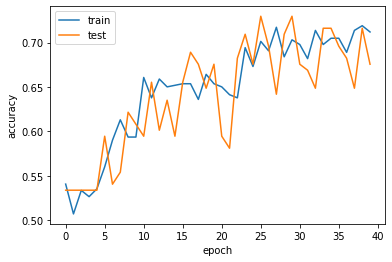

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

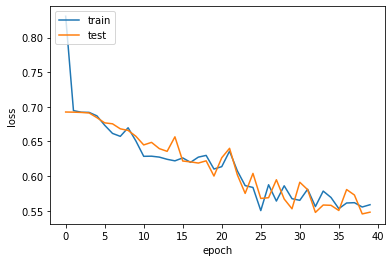

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
LC_train_datagen=ImageDataGenerator(rescale=1/255.0,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True
    ) 
LC_test_datagen=ImageDataGenerator(rescale=1/255.0,horizontal_flip=True)

In [31]:
LC_train_dir=os.path.join('/content/Train/LC')
LC_test_dir=os.path.join('/content/Test/LC')

image_shape=200

LC_train_generator=LC_train_datagen.flow_from_directory(LC_train_dir,
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 target_size=(image_shape,image_shape))

LC_test_generator=LC_test_datagen.flow_from_directory(LC_test_dir,
                                               batch_size=32,
                                               class_mode='binary',
                                               target_size=(image_shape,image_shape))

Found 438 images belonging to 2 classes.
Found 108 images belonging to 2 classes.


In [32]:
tf.random.set_seed(123)
model2=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(200,200,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [33]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 99, 99, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 32)       

In [34]:
model2.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

batch_size=32
history2=model2.fit(LC_train_generator,steps_per_epoch = LC_train_generator.samples // batch_size,
    epochs=40,validation_data=LC_test_generator)

Epoch 1/40
13/13 [==============================] - 8s 531ms/step - loss: 0.8687 - accuracy: 0.4828 - val_loss: 0.6922 - val_accuracy: 0.5370
Epoch 2/40
13/13 [==============================] - 6s 487ms/step - loss: 0.6923 - accuracy: 0.5493 - val_loss: 0.6919 - val_accuracy: 0.5370
Epoch 3/40
13/13 [==============================] - 6s 487ms/step - loss: 0.6946 - accuracy: 0.5443 - val_loss: 0.6921 - val_accuracy: 0.5370
Epoch 4/40
13/13 [==============================] - 6s 493ms/step - loss: 0.6955 - accuracy: 0.5394 - val_loss: 0.6914 - val_accuracy: 0.5370
Epoch 5/40
13/13 [==============================] - 6s 488ms/step - loss: 0.6916 - accuracy: 0.5222 - val_loss: 0.6914 - val_accuracy: 0.5370
Epoch 6/40
13/13 [==============================] - 6s 487ms/step - loss: 0.6912 - accuracy: 0.5369 - val_loss: 0.6841 - val_accuracy: 0.5370
Epoch 7/40
13/13 [==============================] - 6s 488ms/step - loss: 0.6840 - accuracy: 0.5296 - val_loss: 0.6691 - val_accuracy: 0.5370
Epoch 

In [35]:
model2.evaluate(LC_test_generator)

4/4 [==============================] - 1s 138ms/step - loss: 0.5555 - accuracy: 0.7222


[0.5555374026298523, 0.7222222089767456]

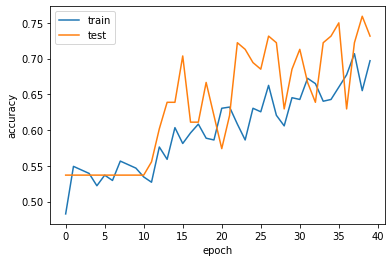

In [36]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

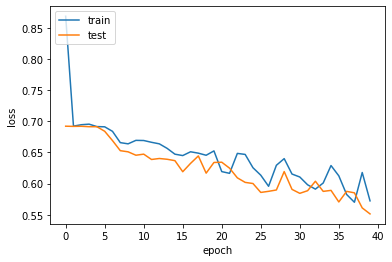

In [37]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
# COVID Model 저장
model.save('/content/gdrive/MyDrive/2021-2/2학기과목/딥러닝/프로젝트/result/model1.h5')

In [41]:
# Lung Cancer Model 저장
model2.save('/content/gdrive/MyDrive/2021-2/2학기과목/딥러닝/프로젝트/result/model2.h5')